In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Descargar recursos necesarios de nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ruta de los 1 archivo(datasets) en Google Drive
ruta_archivo1 = "/content/drive/MyDrive/TFM2 Coronel Joel/TFM Compartido/Books_balanceado30k.csv"

# Lee los archivos de Excel en un DataFrame de pandas
df_books = pd.read_csv(ruta_archivo1)

In [ ]:
from tabulate import tabulate

# Escoger 5 filas aleatorias de los 2 DataFrame
filas_aleatorias1 = df_books.sample(10)

# Mostrar el Dataframe comentarios de manera más bonita utilizando tabulate
print(tabulate(filas_aleatorias1, headers='keys', tablefmt='fancy_grid'))

╒═══════╤════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════╤════════════════╤═══════════════════════════════════════════════╤══════════════════════╤════════════════╤═══════════════╤═══════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

In [ ]:
print(df_books.shape)

(30000, 10)


In [ ]:
df = df_books[['review/score','review/text']]

In [ ]:
# Eliminar las filas que tienen el número 3
df = df[df['review/score'] != 3]

# Recorrer la columna y hacer los cambios
for index, value in df['review/score'].items():
    if value > 3:
        df.at[index, 'review/score'] = 1
    elif value < 3:
        df.at[index, 'review/score'] = 0

In [ ]:
# Convertir la columna a entero
df['review/score'] = df['review/score'].astype(int)

# Imprimir el DataFrame modificado
print("\nDataFrame modificado:")
print(df)


DataFrame modificado:
       review/score                                        review/text
0                 1  This is the original murder mystery novel. It ...
1                 1  Being able to do this program from the privacy...
2                 1  Main Idea:The seas and oceans around the world...
3                 1  I almost closed the book when the first acknow...
4                 1  Who'd have thought that a book about a crooked...
...             ...                                                ...
29995             0  When I saw a new Kellerman book, I snapped it ...
29996             0  As to the best of my knowledge, there were two...
29997             0  I had to read this over the summer for my Engl...
29998             0  The Mayor of Casterbridge was a very interesti...
29999             0  Hoping to capitalize on his fame as a yachtsma...

[24000 rows x 2 columns]


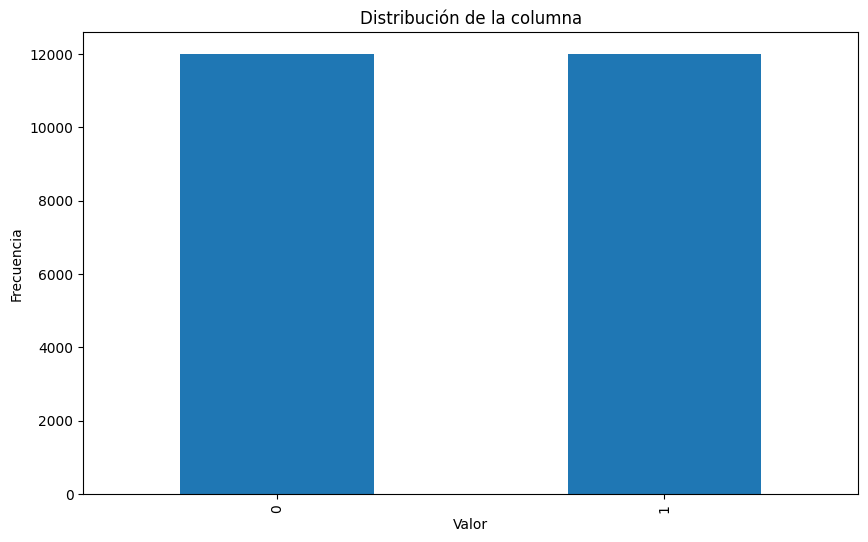

Distribución de la columna:
review/score
1    12000
0    12000
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Graficar la distribución de la columna
plt.figure(figsize=(10, 6))
df['review/score'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de la columna')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

# Verificar si está balanceada
print("Distribución de la columna:")
print(df['review/score'].value_counts())

Preprocesar los datos:

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenización del texto
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['review'])
X = tokenizer.texts_to_sequences(df['review'])
X = pad_sequences(X, maxlen=100)  # Padeo a una longitud máxima de 100 palabras

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Descargar recursos necesarios de nltk
nltk.download('punkt')
nltk.download('stopwords')

# Eliminar filas con valores nulos
df.dropna(inplace=True)

# Convertir a minúsculas
df['review/text'] = df['review/text'].str.lower()

# Eliminar caracteres no alfabéticos y tokenizar
def preprocess_text(text):
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha()]
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

df['review/text'] = df['review/text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dividir el dataset en conjuntos de entrenamiento, prueba y validación

In [ ]:
# Tokenización del texto
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['review/text'])
X = tokenizer.texts_to_sequences(df['review/text'])
X = pad_sequences(X, maxlen=250)  # Padeo a una longitud máxima de 100 palabras

# Dividir el conjunto de datos en entrenamiento, validación y prueba
y = df['review/score'].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)  # 70% entrenamiento, 30% temporal
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)  # 15% validación, 15% prueba

# Verificar el balanceo de clases en cada conjunto de datos
def check_balance(y_data, dataset_name):
    unique, counts = np.unique(y_data, return_counts=True)
    balance = dict(zip(unique, counts))
    print(f"Balanceo de clases en {dataset_name}: {balance}")

check_balance(y_train, "entrenamiento")
check_balance(y_val, "validación")
check_balance(y_test, "prueba")

Balanceo de clases en entrenamiento: {0: 8400, 1: 8400}
Balanceo de clases en validación: {0: 1800, 1: 1800}
Balanceo de clases en prueba: {0: 1800, 1: 1800}


#Función para Evaluar los Modelos

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, X_test, y_test, dataset_name):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy en {dataset_name}: {accuracy}')
    print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Matriz de confusión en {dataset_name}')
    plt.show()

# Modelo Naive Bayes

Accuracy en prueba: 0.82125
              precision    recall  f1-score   support

    negative       0.82      0.82      0.82      2409
    positive       0.82      0.83      0.82      2391

    accuracy                           0.82      4800
   macro avg       0.82      0.82      0.82      4800
weighted avg       0.82      0.82      0.82      4800



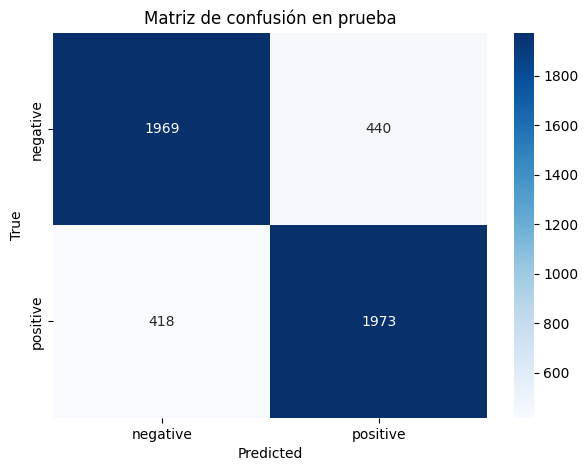

In [ ]:
# Vectorización usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['review/text']).toarray()
y = df['review/score'].values

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Evaluar el modelo
evaluate_model(nb_model, X_test, y_test, 'prueba')

# Evaluar el modelo con el conjunto de validación
#evaluate_model(nb_model, X_val, y_val, 'validación')

#Logistic Regression

Accuracy en prueba: 0.836875
              precision    recall  f1-score   support

    negative       0.84      0.83      0.84      2409
    positive       0.83      0.85      0.84      2391

    accuracy                           0.84      4800
   macro avg       0.84      0.84      0.84      4800
weighted avg       0.84      0.84      0.84      4800



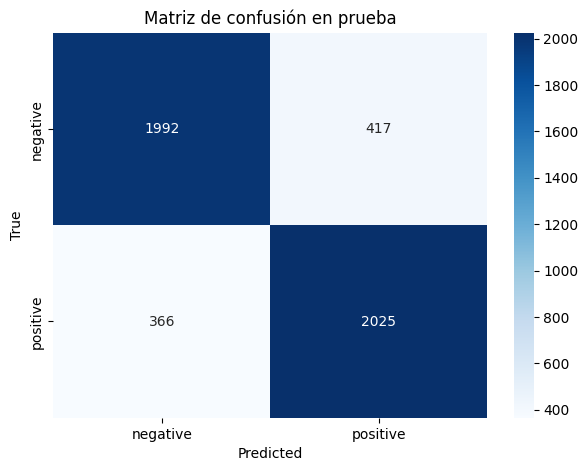

In [ ]:
# Modelo Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Evaluar el modelo
evaluate_model(lr_model, X_test, y_test, 'prueba')

# Evaluar el modelo con el conjunto de validación
#evaluate_model(lr_model, X_val, y_val, 'validación')

#Support Vector Machine

Accuracy en prueba: 0.84125
              precision    recall  f1-score   support

    negative       0.85      0.83      0.84      2409
    positive       0.83      0.85      0.84      2391

    accuracy                           0.84      4800
   macro avg       0.84      0.84      0.84      4800
weighted avg       0.84      0.84      0.84      4800



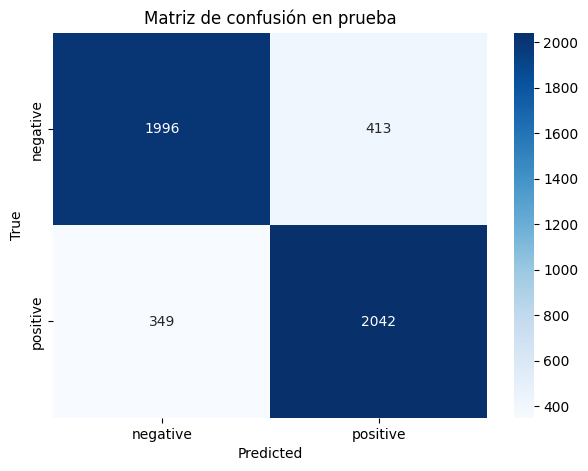

In [ ]:
# Modelo Support Vector Machine
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Evaluar el modelo
evaluate_model(svm_model, X_test, y_test, 'prueba')

# Evaluar el modelo con el conjunto de validación
#evaluate_model(svm_model, X_val, y_val, 'validación')

Modelos Basados en Redes Neuronales
#Long Short-Term Memory (LSTM)

Epoch 1/5
270/270 [==============================] - 74s 251ms/step - loss: 0.4785 - accuracy: 0.7725 - val_loss: 0.3873 - val_accuracy: 0.8323
Epoch 2/5
270/270 [==============================] - 58s 215ms/step - loss: 0.3298 - accuracy: 0.8619 - val_loss: 0.3976 - val_accuracy: 0.8182
Epoch 3/5
270/270 [==============================] - 55s 203ms/step - loss: 0.2667 - accuracy: 0.8912 - val_loss: 0.4321 - val_accuracy: 0.8156
Epoch 4/5
270/270 [==============================] - 54s 201ms/step - loss: 0.2180 - accuracy: 0.9159 - val_loss: 0.5275 - val_accuracy: 0.8099
Epoch 5/5
150/150 [==============================] - 4s 28ms/step
Accuracy en prueba: 0.8079166666666666
              precision    recall  f1-score   support

    negative       0.79      0.83      0.81      2409
    positive       0.82      0.78      0.80      2391

    accuracy                           0.81      4800
   macro avg       0.81      0.81      0.81      4800
weighted avg       0.81      0.81      0.81    

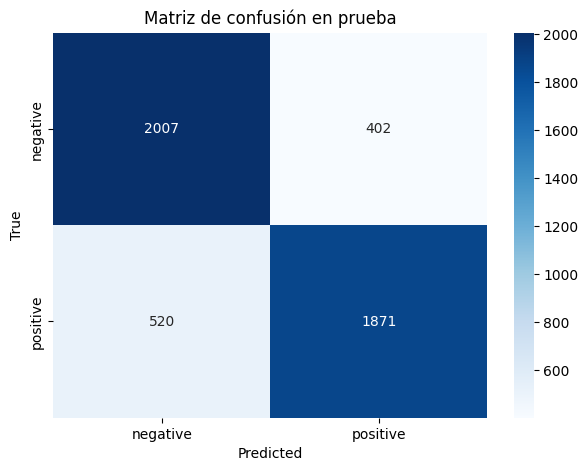

113/113 [==============================] - 8s 71ms/step
Accuracy en validación: 0.9266666666666666
              precision    recall  f1-score   support

    negative       0.93      0.93      0.93      1800
    positive       0.93      0.93      0.93      1800

    accuracy                           0.93      3600
   macro avg       0.93      0.93      0.93      3600
weighted avg       0.93      0.93      0.93      3600



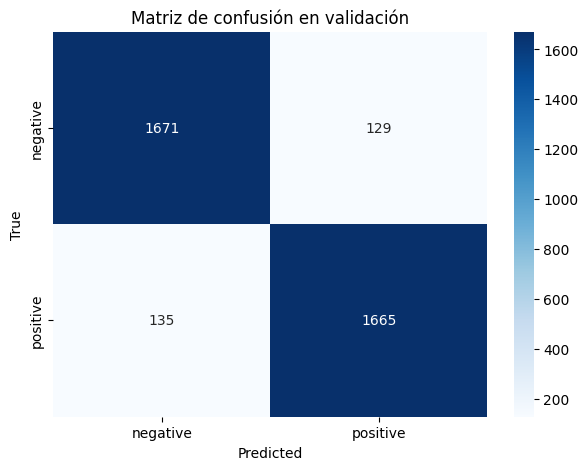

Epoch 1/5
270/270 [==============================] - 70s 253ms/step - loss: 0.4830 - accuracy: 0.7642 - val_loss: 0.4138 - val_accuracy: 0.8125
Epoch 2/5
270/270 [==============================] - 59s 217ms/step - loss: 0.3307 - accuracy: 0.8611 - val_loss: 0.4008 - val_accuracy: 0.8130
Epoch 3/5
270/270 [==============================] - 55s 203ms/step - loss: 0.2719 - accuracy: 0.8903 - val_loss: 0.4525 - val_accuracy: 0.8161
Epoch 4/5
270/270 [==============================] - 53s 198ms/step - loss: 0.2274 - accuracy: 0.9114 - val_loss: 0.4601 - val_accuracy: 0.8005
Epoch 5/5
150/150 [==============================] - 5s 35ms/step
Accuracy en prueba: 0.8154166666666667
              precision    recall  f1-score   support

    negative       0.82      0.81      0.81      2409
    positive       0.81      0.82      0.82      2391

    accuracy                           0.82      4800
   macro avg       0.82      0.82      0.82      4800
weighted avg       0.82      0.82      0.82    

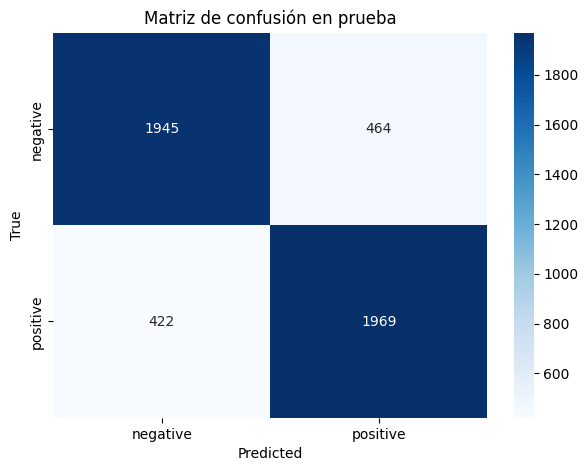

113/113 [==============================] - 8s 65ms/step
Accuracy en validación: 0.9275
              precision    recall  f1-score   support

    negative       0.94      0.91      0.93      1800
    positive       0.91      0.94      0.93      1800

    accuracy                           0.93      3600
   macro avg       0.93      0.93      0.93      3600
weighted avg       0.93      0.93      0.93      3600



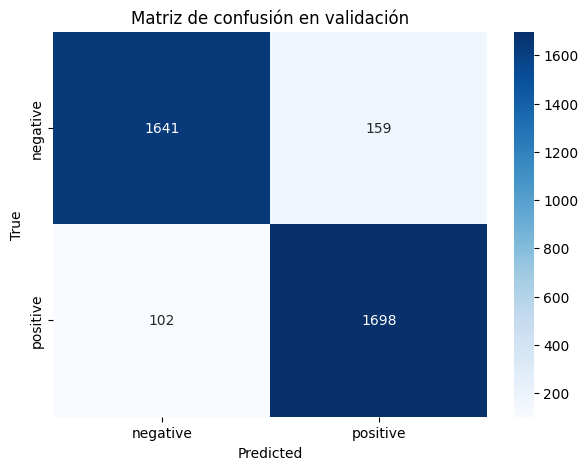

In [ ]:
# Tokenización del texto
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['review/text'])
X = tokenizer.texts_to_sequences(df['review/text'])
X = pad_sequences(X, maxlen=100)  # Padeo a una longitud máxima de 100 palabras

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construir el modelo LSTM
lstm_model = Sequential()
lstm_model.add(Embedding(5000, 128, input_length=100))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluar el modelo
evaluate_model(lstm_model, X_test, y_test, 'prueba')

# Evaluar el modelo con el conjunto de validación
evaluate_model(lstm_model, X_val, y_val, 'validación')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Embedding, SpatialDropout1D, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Convolutional Neural Network (CNN)

Epoch 1/5
270/270 [==============================] - 23s 77ms/step - loss: 0.5278 - accuracy: 0.7135 - val_loss: 0.4099 - val_accuracy: 0.8203
Epoch 2/5
270/270 [==============================] - 9s 33ms/step - loss: 0.3182 - accuracy: 0.8681 - val_loss: 0.4077 - val_accuracy: 0.8182
Epoch 3/5
270/270 [==============================] - 6s 21ms/step - loss: 0.1859 - accuracy: 0.9365 - val_loss: 0.4645 - val_accuracy: 0.8109
Epoch 4/5
270/270 [==============================] - 4s 16ms/step - loss: 0.0824 - accuracy: 0.9804 - val_loss: 0.5731 - val_accuracy: 0.8078
Epoch 5/5
150/150 [==============================] - 1s 3ms/step
Accuracy en prueba: 0.818125
              precision    recall  f1-score   support

    negative       0.82      0.82      0.82      2409
    positive       0.82      0.82      0.82      2391

    accuracy                           0.82      4800
   macro avg       0.82      0.82      0.82      4800
weighted avg       0.82      0.82      0.82      4800



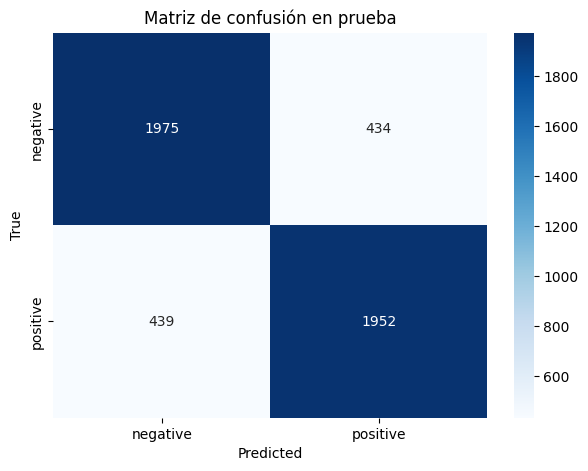

113/113 [==============================] - 0s 2ms/step
Accuracy en validación: 0.9583333333333334
              precision    recall  f1-score   support

    negative       0.97      0.94      0.96      1800
    positive       0.94      0.97      0.96      1800

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



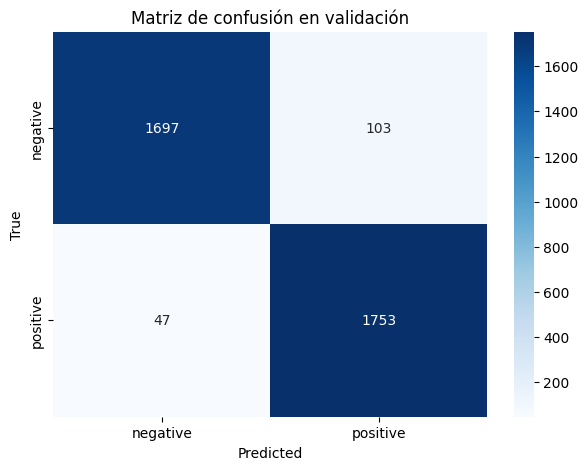

Epoch 1/5
270/270 [==============================] - 21s 75ms/step - loss: 0.5126 - accuracy: 0.7417 - val_loss: 0.4062 - val_accuracy: 0.8198
Epoch 2/5
270/270 [==============================] - 9s 32ms/step - loss: 0.2893 - accuracy: 0.8845 - val_loss: 0.4076 - val_accuracy: 0.8151
Epoch 3/5
270/270 [==============================] - 7s 25ms/step - loss: 0.1488 - accuracy: 0.9520 - val_loss: 0.4611 - val_accuracy: 0.8177
Epoch 4/5
270/270 [==============================] - 4s 16ms/step - loss: 0.0552 - accuracy: 0.9881 - val_loss: 0.5671 - val_accuracy: 0.8125
Epoch 5/5
150/150 [==============================] - 0s 2ms/step
Accuracy en prueba: 0.8216666666666667
              precision    recall  f1-score   support

    negative       0.81      0.84      0.83      2409
    positive       0.83      0.80      0.82      2391

    accuracy                           0.82      4800
   macro avg       0.82      0.82      0.82      4800
weighted avg       0.82      0.82      0.82      4800



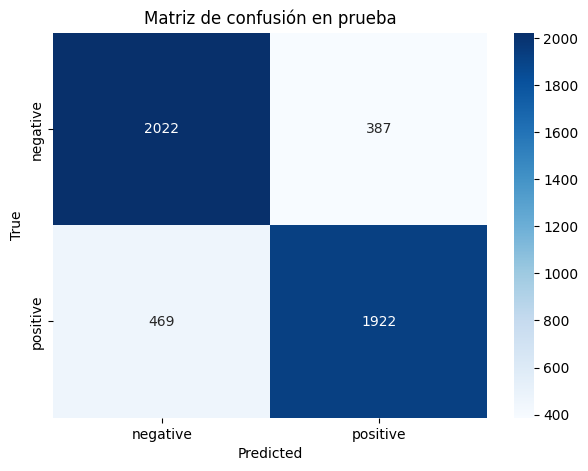

113/113 [==============================] - 0s 2ms/step
Accuracy en validación: 0.9597222222222223
              precision    recall  f1-score   support

    negative       0.97      0.95      0.96      1800
    positive       0.95      0.97      0.96      1800

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



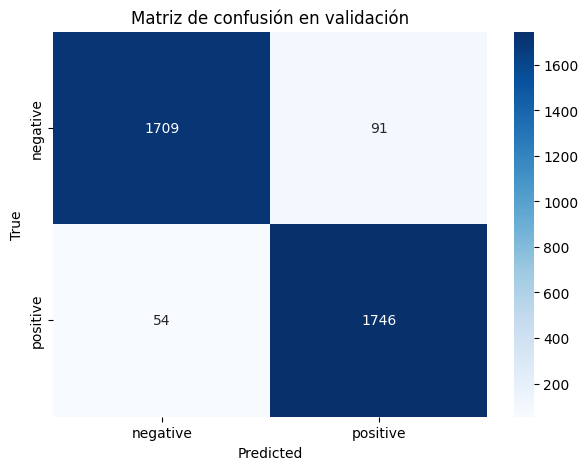

In [ ]:
# Construir el modelo CNN
cnn_model = Sequential()
cnn_model.add(Embedding(5000, 128, input_length=100))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
cnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluar el modelo
evaluate_model(cnn_model, X_test, y_test, 'prueba')

# Evaluar el modelo con el conjunto de validación
evaluate_model(cnn_model, X_val, y_val, 'validación')

#Recurrent Neural Network (RNN)

Epoch 1/5
270/270 [==============================] - 44s 158ms/step - loss: 0.6797 - accuracy: 0.5594 - val_loss: 0.5158 - val_accuracy: 0.7474
Epoch 2/5
270/270 [==============================] - 32s 120ms/step - loss: 0.4852 - accuracy: 0.7704 - val_loss: 0.5208 - val_accuracy: 0.7646
Epoch 3/5
270/270 [==============================] - 28s 106ms/step - loss: 0.4072 - accuracy: 0.8239 - val_loss: 0.4561 - val_accuracy: 0.8010
Epoch 4/5
270/270 [==============================] - 27s 100ms/step - loss: 0.3693 - accuracy: 0.8448 - val_loss: 0.6060 - val_accuracy: 0.7745
Epoch 5/5
150/150 [==============================] - 1s 8ms/step
Accuracy en prueba: 0.7854166666666667
              precision    recall  f1-score   support

    negative       0.79      0.78      0.78      2409
    positive       0.78      0.79      0.79      2391

    accuracy                           0.79      4800
   macro avg       0.79      0.79      0.79      4800
weighted avg       0.79      0.79      0.79     

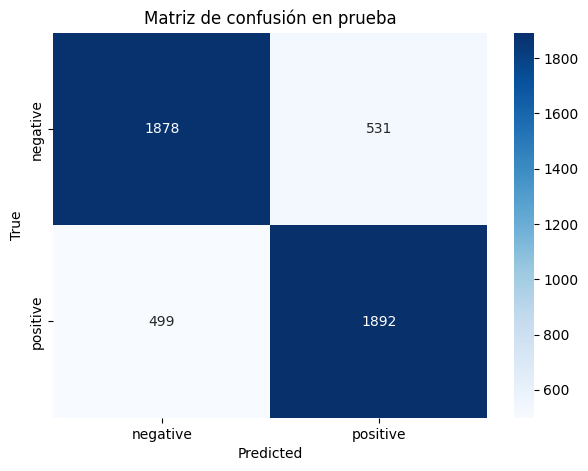

113/113 [==============================] - 3s 22ms/step
Accuracy en validación: 0.8141666666666667
              precision    recall  f1-score   support

    negative       0.82      0.80      0.81      1800
    positive       0.81      0.83      0.82      1800

    accuracy                           0.81      3600
   macro avg       0.81      0.81      0.81      3600
weighted avg       0.81      0.81      0.81      3600



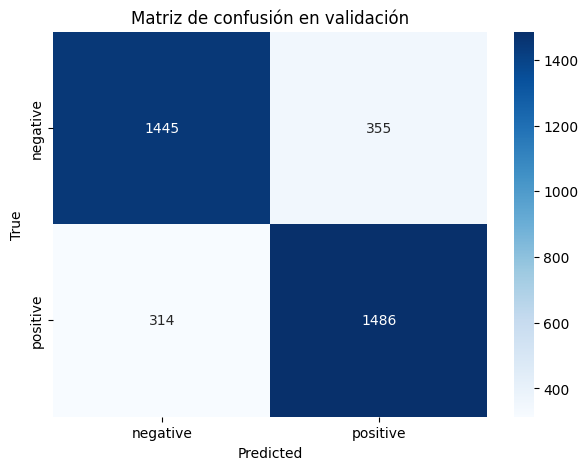

Epoch 1/5
270/270 [==============================] - 46s 167ms/step - loss: 0.6859 - accuracy: 0.5557 - val_loss: 0.5560 - val_accuracy: 0.7271
Epoch 2/5
270/270 [==============================] - 35s 128ms/step - loss: 0.4911 - accuracy: 0.7675 - val_loss: 0.4920 - val_accuracy: 0.7891
Epoch 3/5
270/270 [==============================] - 31s 113ms/step - loss: 0.3912 - accuracy: 0.8345 - val_loss: 0.4991 - val_accuracy: 0.7964
Epoch 4/5
270/270 [==============================] - 28s 103ms/step - loss: 0.3621 - accuracy: 0.8467 - val_loss: 0.7055 - val_accuracy: 0.7620
Epoch 5/5
150/150 [==============================] - 2s 12ms/step
Accuracy en prueba: 0.7802083333333333
              precision    recall  f1-score   support

    negative       0.80      0.75      0.77      2409
    positive       0.76      0.81      0.79      2391

    accuracy                           0.78      4800
   macro avg       0.78      0.78      0.78      4800
weighted avg       0.78      0.78      0.78    

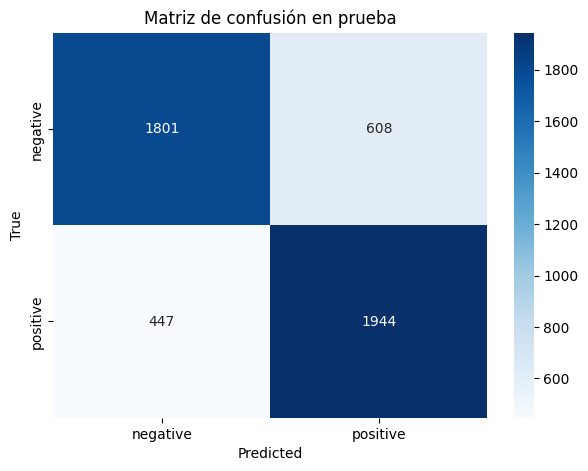

113/113 [==============================] - 2s 19ms/step
Accuracy en validación: 0.8427777777777777
              precision    recall  f1-score   support

    negative       0.87      0.81      0.84      1800
    positive       0.82      0.88      0.85      1800

    accuracy                           0.84      3600
   macro avg       0.84      0.84      0.84      3600
weighted avg       0.84      0.84      0.84      3600



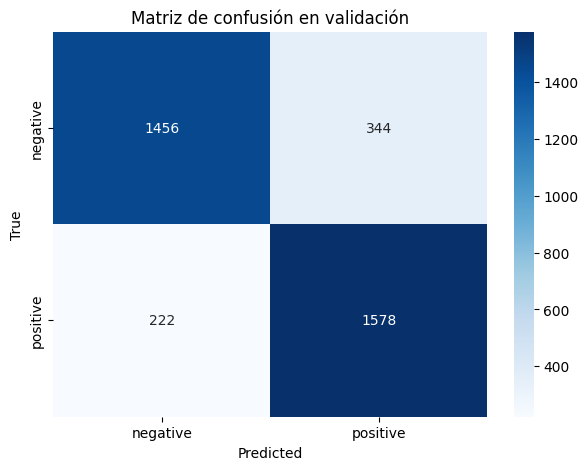

In [ ]:
# Construir el modelo RNN
rnn_model = Sequential()
rnn_model.add(Embedding(5000, 128, input_length=100))
rnn_model.add(SimpleRNN(100, dropout=0.2, recurrent_dropout=0.2))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
rnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluar el modelo
evaluate_model(rnn_model, X_test, y_test, 'prueba')

# Evaluar el modelo con el conjunto de validación
evaluate_model(rnn_model, X_val, y_val, 'validación')

#Gated Recurrent Unit (GRU)

Epoch 1/5
270/270 [==============================] - 70s 246ms/step - loss: 0.5138 - accuracy: 0.7385 - val_loss: 0.4356 - val_accuracy: 0.8104
Epoch 2/5
270/270 [==============================] - 59s 219ms/step - loss: 0.3421 - accuracy: 0.8552 - val_loss: 0.3936 - val_accuracy: 0.8271
Epoch 3/5
270/270 [==============================] - 53s 198ms/step - loss: 0.2849 - accuracy: 0.8849 - val_loss: 0.4070 - val_accuracy: 0.8271
Epoch 4/5
270/270 [==============================] - 51s 189ms/step - loss: 0.2261 - accuracy: 0.9115 - val_loss: 0.4348 - val_accuracy: 0.8224
Epoch 5/5
150/150 [==============================] - 6s 36ms/step
Accuracy en prueba: 0.8133333333333334
              precision    recall  f1-score   support

    negative       0.82      0.81      0.81      2409
    positive       0.81      0.81      0.81      2391

    accuracy                           0.81      4800
   macro avg       0.81      0.81      0.81      4800
weighted avg       0.81      0.81      0.81    

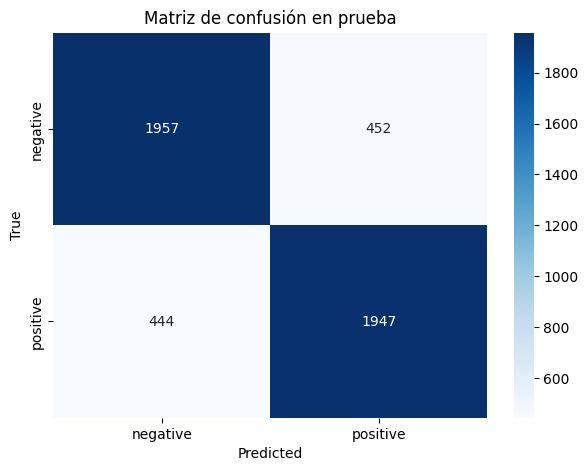

113/113 [==============================] - 9s 77ms/step
Accuracy en validación: 0.9322222222222222
              precision    recall  f1-score   support

    negative       0.95      0.91      0.93      1800
    positive       0.92      0.95      0.93      1800

    accuracy                           0.93      3600
   macro avg       0.93      0.93      0.93      3600
weighted avg       0.93      0.93      0.93      3600



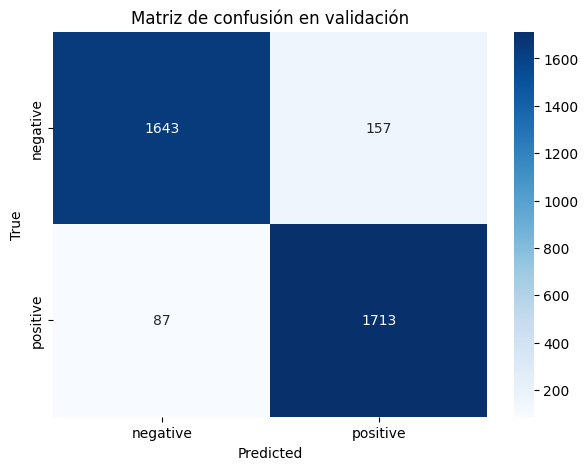

Epoch 1/5
270/270 [==============================] - 72s 258ms/step - loss: 0.4914 - accuracy: 0.7528 - val_loss: 0.4461 - val_accuracy: 0.8161
Epoch 2/5
270/270 [==============================] - 59s 220ms/step - loss: 0.3380 - accuracy: 0.8595 - val_loss: 0.4086 - val_accuracy: 0.8193
Epoch 3/5
270/270 [==============================] - 56s 208ms/step - loss: 0.2769 - accuracy: 0.8891 - val_loss: 0.4114 - val_accuracy: 0.8182
Epoch 4/5
270/270 [==============================] - 54s 199ms/step - loss: 0.2193 - accuracy: 0.9146 - val_loss: 0.4558 - val_accuracy: 0.8125
Epoch 5/5
150/150 [==============================] - 5s 35ms/step
Accuracy en prueba: 0.811875
              precision    recall  f1-score   support

    negative       0.82      0.80      0.81      2409
    positive       0.80      0.82      0.81      2391

    accuracy                           0.81      4800
   macro avg       0.81      0.81      0.81      4800
weighted avg       0.81      0.81      0.81      4800



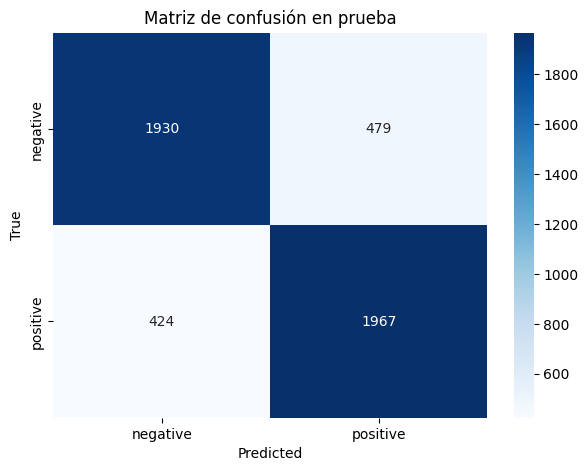

113/113 [==============================] - 10s 86ms/step
Accuracy en validación: 0.935
              precision    recall  f1-score   support

    negative       0.95      0.92      0.93      1800
    positive       0.92      0.95      0.94      1800

    accuracy                           0.94      3600
   macro avg       0.94      0.94      0.93      3600
weighted avg       0.94      0.94      0.93      3600



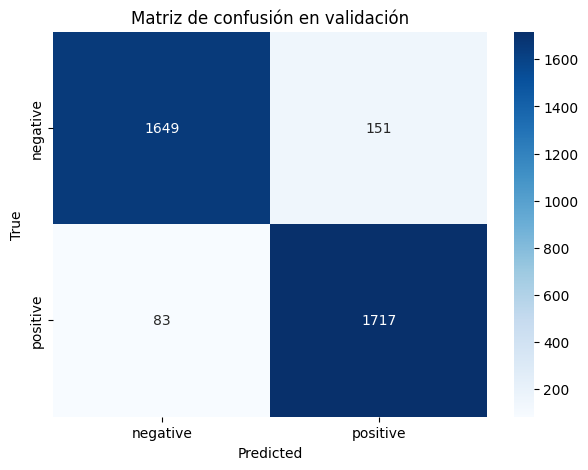

In [ ]:
# Construir el modelo GRU
gru_model = Sequential()
gru_model.add(Embedding(5000, 128, input_length=100))
gru_model.add(SpatialDropout1D(0.2))
gru_model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
gru_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluar el modelo
evaluate_model(gru_model, X_test, y_test, 'prueba')

# Evaluar el modelo con el conjunto de validación
evaluate_model(gru_model, X_val, y_val, 'validación')